In [2]:
# License: BSD
# Author: Sasank Chilamkurthy
# source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

c:\Users\Surface\.conda\envs\newCloneWithCaptum\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dtd_dir = '../data/dtd/images'
labels = np.array(os.listdir(dtd_dir))

import random
random.seed(1)
random_labels = random.sample(range(0, 46), 10)

labels = list(labels[random_labels])
labels

['fibrous',
 'knitted',
 'waffled',
 'lined',
 'bubbly',
 'honeycombed',
 'veined',
 'polka-dotted',
 'zigzagged',
 'crosshatched']

In [73]:
import shutil
from tqdm import tqdm

for label in labels:
    print(f"LABEL = {label}")

    imgs = os.listdir(dtd_dir + "/" + label)
    random.seed(1)
    random.shuffle(imgs)
    imgs_dir = [dtd_dir + "/" + label + "/" + i for i in imgs]

    train_imgs = imgs_dir[0:80]
    test_imgs = imgs_dir[80:100]
    val_imgs = imgs_dir[100:120]

    print("splitting and copying training images....")
    train_dir = '../data/training_data/train/' + label
    os.mkdir(train_dir)
    for i_dir in tqdm(train_imgs):
        shutil.copy(i_dir, train_dir)

    print("splitting and copying validation images....")
    val_dir = '../data/training_data/val/' + label
    os.mkdir(val_dir)
    for i_dir in tqdm(val_imgs):
        shutil.copy(i_dir, val_dir)

    print("splitting and copying testing images....")
    test_dir = '../data/test'
    test_dir = '../data/test/' + label
    os.mkdir(test_dir)
    for i_dir in tqdm(test_imgs):
        shutil.copy(i_dir, test_dir)
    
    

LABEL = fibrous
splitting and copying training images....


100%|██████████| 80/80 [00:05<00:00, 14.19it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:00<00:00, 20.61it/s]


LABEL = knitted
splitting and copying training images....


100%|██████████| 80/80 [00:04<00:00, 18.92it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:00<00:00, 20.36it/s]


LABEL = waffled
splitting and copying training images....


100%|██████████| 80/80 [00:06<00:00, 12.24it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 10.92it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:01<00:00, 11.79it/s]


LABEL = lined
splitting and copying training images....


100%|██████████| 80/80 [00:04<00:00, 16.59it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


LABEL = bubbly
splitting and copying training images....


100%|██████████| 80/80 [00:05<00:00, 14.35it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 10.90it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]


LABEL = honeycombed
splitting and copying training images....


100%|██████████| 80/80 [00:06<00:00, 13.16it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 16.44it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


LABEL = veined
splitting and copying training images....


100%|██████████| 80/80 [00:09<00:00,  8.68it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:02<00:00,  7.05it/s]


LABEL = polka-dotted
splitting and copying training images....


100%|██████████| 80/80 [00:06<00:00, 12.12it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 11.39it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


LABEL = zigzagged
splitting and copying training images....


100%|██████████| 80/80 [00:07<00:00, 10.83it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:01<00:00, 15.49it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:01<00:00, 10.75it/s]


LABEL = crosshatched
splitting and copying training images....


100%|██████████| 80/80 [00:07<00:00, 10.44it/s]


splitting and copying validation images....


100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


splitting and copying testing images....


100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/training_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

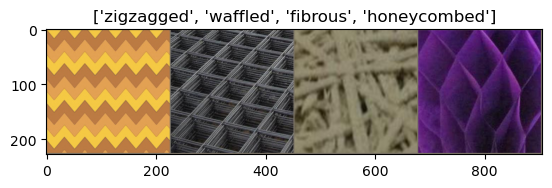

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [11]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|██████████| 200/200 [09:48<00:00,  2.94s/it]


train Loss: 1.5407 Acc: 0.4844


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


val Loss: 1.1988 Acc: 0.6750

Epoch 1/24
----------


100%|██████████| 200/200 [10:09<00:00,  3.05s/it]


train Loss: 1.2576 Acc: 0.5957


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


val Loss: 0.8928 Acc: 0.7700

Epoch 2/24
----------


100%|██████████| 200/200 [10:01<00:00,  3.01s/it]


train Loss: 1.0948 Acc: 0.6508


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


val Loss: 0.6880 Acc: 0.8150

Epoch 3/24
----------


100%|██████████| 200/200 [10:00<00:00,  3.00s/it]


train Loss: 1.0565 Acc: 0.6771


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


val Loss: 1.1973 Acc: 0.7100

Epoch 4/24
----------


100%|██████████| 200/200 [10:02<00:00,  3.01s/it]


train Loss: 0.8758 Acc: 0.7234


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


val Loss: 0.9240 Acc: 0.7800

Epoch 5/24
----------


100%|██████████| 200/200 [10:10<00:00,  3.05s/it]


train Loss: 0.9203 Acc: 0.7247


100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


val Loss: 1.1051 Acc: 0.7900

Epoch 6/24
----------


100%|██████████| 200/200 [09:37<00:00,  2.89s/it]


train Loss: 0.8719 Acc: 0.7434


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


val Loss: 1.1509 Acc: 0.7700

Epoch 7/24
----------


100%|██████████| 200/200 [09:31<00:00,  2.86s/it]


train Loss: 0.6444 Acc: 0.8135


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.7499 Acc: 0.8050

Epoch 8/24
----------


100%|██████████| 200/200 [09:24<00:00,  2.82s/it]


train Loss: 0.6131 Acc: 0.8098


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


val Loss: 0.8337 Acc: 0.8250

Epoch 9/24
----------


100%|██████████| 200/200 [09:30<00:00,  2.85s/it]


train Loss: 0.5351 Acc: 0.8310


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.6723 Acc: 0.8400

Epoch 10/24
----------


100%|██████████| 200/200 [09:30<00:00,  2.85s/it]


train Loss: 0.4469 Acc: 0.8773


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


val Loss: 0.5432 Acc: 0.8500

Epoch 11/24
----------


100%|██████████| 200/200 [09:21<00:00,  2.81s/it]


train Loss: 0.4436 Acc: 0.8686


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


val Loss: 0.5352 Acc: 0.8550

Epoch 12/24
----------


100%|██████████| 200/200 [09:17<00:00,  2.79s/it]


train Loss: 0.4556 Acc: 0.8598


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


val Loss: 0.6129 Acc: 0.8450

Epoch 13/24
----------


100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


train Loss: 0.4288 Acc: 0.8698


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


val Loss: 0.5879 Acc: 0.8600

Epoch 14/24
----------


100%|██████████| 200/200 [09:17<00:00,  2.79s/it]


train Loss: 0.4034 Acc: 0.8786


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.6829 Acc: 0.8300

Epoch 15/24
----------


100%|██████████| 200/200 [09:23<00:00,  2.82s/it]


train Loss: 0.3970 Acc: 0.8761


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


val Loss: 0.6561 Acc: 0.8600

Epoch 16/24
----------


100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


train Loss: 0.4045 Acc: 0.8736


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.7844 Acc: 0.8000

Epoch 17/24
----------


100%|██████████| 200/200 [09:23<00:00,  2.82s/it]


train Loss: 0.4206 Acc: 0.8686


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.5400 Acc: 0.8800

Epoch 18/24
----------


100%|██████████| 200/200 [09:23<00:00,  2.82s/it]


train Loss: 0.4215 Acc: 0.8561


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


val Loss: 0.5817 Acc: 0.8600

Epoch 19/24
----------


100%|██████████| 200/200 [09:32<00:00,  2.86s/it]


train Loss: 0.3701 Acc: 0.8924


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


val Loss: 0.5309 Acc: 0.8850

Epoch 20/24
----------


100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


train Loss: 0.4512 Acc: 0.8598


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.6368 Acc: 0.8400

Epoch 21/24
----------


100%|██████████| 200/200 [09:22<00:00,  2.81s/it]


train Loss: 0.4471 Acc: 0.8623


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


val Loss: 0.4882 Acc: 0.8850

Epoch 22/24
----------


100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


train Loss: 0.3825 Acc: 0.8849


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


val Loss: 0.5662 Acc: 0.8850

Epoch 23/24
----------


100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


train Loss: 0.4163 Acc: 0.8798


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


val Loss: 0.5802 Acc: 0.8700

Epoch 24/24
----------


100%|██████████| 200/200 [09:26<00:00,  2.83s/it]


train Loss: 0.3469 Acc: 0.8886


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


val Loss: 0.4450 Acc: 0.8900

Training complete in 260m 27s
Best val Acc: 0.890000


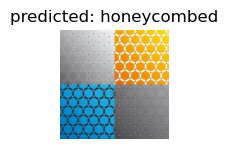

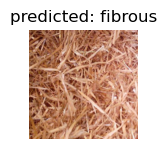

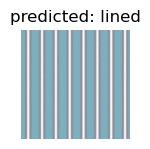

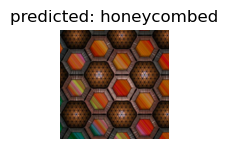

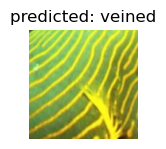

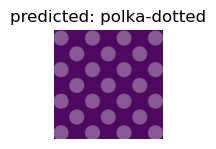

In [13]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [15]:
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir = '../data'
image_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
dataloader = torch.utils.data.DataLoader(image_test_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
test_dataset_size = len(image_test_dataset)

In [16]:
# source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# prepare to count predictions for each class
classes = image_test_dataset.classes
print(classes)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = model_ft(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f"correct_pred = {correct_pred}")
print(f"total_pred = {total_pred}")

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

['bubbly', 'crosshatched', 'fibrous', 'honeycombed', 'knitted', 'lined', 'polka-dotted', 'veined', 'waffled', 'zigzagged']
correct_pred = {'bubbly': 18, 'crosshatched': 15, 'fibrous': 20, 'honeycombed': 19, 'knitted': 16, 'lined': 20, 'polka-dotted': 17, 'veined': 16, 'waffled': 19, 'zigzagged': 17}
total_pred = {'bubbly': 20, 'crosshatched': 20, 'fibrous': 20, 'honeycombed': 20, 'knitted': 20, 'lined': 20, 'polka-dotted': 20, 'veined': 20, 'waffled': 20, 'zigzagged': 20}
Accuracy for class: bubbly is 90.0 %
Accuracy for class: crosshatched is 75.0 %
Accuracy for class: fibrous is 100.0 %
Accuracy for class: honeycombed is 95.0 %
Accuracy for class: knitted is 80.0 %
Accuracy for class: lined is 100.0 %
Accuracy for class: polka-dotted is 85.0 %
Accuracy for class: veined is 80.0 %
Accuracy for class: waffled is 95.0 %
Accuracy for class: zigzagged is 85.0 %


In [17]:
torch.save(model_ft.state_dict(), '../data/dtd_state_dict')
test_model = torchvision.models.resnet50()
num_ftrs = test_model.fc.in_features
test_model.fc = nn.Linear(num_ftrs, 10)
test_model.load_state_dict(torch.load('../data/dtd_state_dict'))

torch.save(model_ft, '../data/dtd_model')
test_model2 = torch.load('../data/dtd_model')

In [18]:
class_dict = {}
label_dict = {}

range_0_9 = range(0,10)
ids_ls = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']

for i, class_i in zip(range_0_9, classes):
    class_dict[str(i)] = [ids_ls[i], class_i]
    label_dict[ids_ls[i]] = i

print(class_dict)
np.save('../Relevance-CAM/dtd_class_dict.npy', class_dict)

print(label_dict)
np.save('../Relevance-CAM/dtd_label_dict.npy', label_dict)

{'0': ['n0', 'bubbly'], '1': ['n1', 'crosshatched'], '2': ['n2', 'fibrous'], '3': ['n3', 'honeycombed'], '4': ['n4', 'knitted'], '5': ['n5', 'lined'], '6': ['n6', 'polka-dotted'], '7': ['n7', 'veined'], '8': ['n8', 'waffled'], '9': ['n9', 'zigzagged']}
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
